# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Classifying-newswires:-a-multiclass-classification-example" data-toc-modified-id="Classifying-newswires:-a-multiclass-classification-example-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Classifying newswires: a multiclass classification example</a></div><div class="lev2 toc-item"><a href="#Vectorize-Data-(one-hot-encoding)" data-toc-modified-id="Vectorize-Data-(one-hot-encoding)-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Vectorize Data (one-hot-encoding)</a></div><div class="lev2 toc-item"><a href="#Use-Less-Epoch" data-toc-modified-id="Use-Less-Epoch-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Use Less Epoch</a></div><div class="lev2 toc-item"><a href="#A-different-way-to-handle-labels-and-loss" data-toc-modified-id="A-different-way-to-handle-labels-and-loss-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>A different way to handle labels and loss</a></div><div class="lev1 toc-item"><a href="#Regression-Example:-The-Boston-Housing-Price-Dataset" data-toc-modified-id="Regression-Example:-The-Boston-Housing-Price-Dataset-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Regression Example: The Boston Housing Price Dataset</a></div><div class="lev3 toc-item"><a href="#Build-Model" data-toc-modified-id="Build-Model-201"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>Build Model</a></div><div class="lev3 toc-item"><a href="#K-fold-Validation-Implementation" data-toc-modified-id="K-fold-Validation-Implementation-202"><span class="toc-item-num">2.0.2&nbsp;&nbsp;</span>K-fold Validation Implementation</a></div><div class="lev3 toc-item"><a href="#Saving-Validation-Log-for-Each-Epoch" data-toc-modified-id="Saving-Validation-Log-for-Each-Epoch-203"><span class="toc-item-num">2.0.3&nbsp;&nbsp;</span>Saving Validation Log for Each Epoch</a></div>

# Classifying newswires: a multiclass classification example

In this section, you’ll build a network to classify Reuters newswires into 46 mutually exclusive topics. Because you have many classes, this problem is an instance of multi- class classification; and because each data point should be classified into only one cate- gory, the problem is more specifically an instance of single-label, multiclass classification. If each data point could belong to multiple categories (in this case, topics), you’d be facing a multilabel, multiclass classification problem.

In [51]:
from tensorflow.keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(
    num_words=10000)

In [52]:
print(train_data.shape) # 2-d numpy.array(), the second tensor index corresponding data is list with different length
print(train_labels.shape) # 1-d array
print(test_data.shape)
print(test_labels.shape)

(8982,)
(8982,)
(2246,)
(2246,)


Check some decoded words/index

In [53]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()]) 
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [54]:
print(decoded_newswire)

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


In [55]:
train_labels[0]

3

## Vectorize Data (one-hot-encoding)

In [56]:
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

In [57]:
x_train = vectorize_sequences(train_data)

In [58]:
x_test = vectorize_sequences(test_data)

In [59]:
x_train.shape

(8982, 10000)

In [60]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results
one_hot_train_labels = to_one_hot(train_labels)
one_hot_test_labels = to_one_hot(test_labels)

Note there is a Keras built-in way to do one-hot encoding.

In [61]:
from keras.utils.np_utils import to_categorical
one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)


In [62]:
print(one_hot_test_labels.shape) # note, we have 46 categories

(2246, 46)


In [63]:
from tensorflow.keras import models
from tensorflow.keras import layers
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

In [64]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                640064    
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 46)                2990      
Total params: 647,214
Trainable params: 647,214
Non-trainable params: 0
_________________________________________________________________


<ul>
<li> There are two other things you should note about this architecture:
You end the network with a Dense layer of size 46. This means for each input sample, the network will output a 46-dimensional vector. Each entry in this vec- tor (each dimension) will encode a different output class.</li>
<li> The last layer uses a softmax activation. You saw this pattern in the MNIST example. It means the network will output a probability distribution over the 46 different output classes—for every input sample, the network will produce a 46- dimensional output vector, where output[i] is the probability that the sample belongs to class i. The 46 scores will sum to 1. </li>
</ul>

In [65]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [66]:
# defin validation data
x_val = x_train[:1000] # fist 1k validation data
partial_x_train = x_train[1000:] # the rest are training data
y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [67]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Epoch 1/20
16/16 [==============================] - 1s 28ms/step - loss: 2.6144 - accuracy: 0.5132 - val_loss: 1.7976 - val_accuracy: 0.6440
Epoch 2/20
16/16 [==============================] - 0s 15ms/step - loss: 1.4898 - accuracy: 0.6918 - val_loss: 1.3738 - val_accuracy: 0.6960
Epoch 3/20
16/16 [==============================] - 0s 14ms/step - loss: 1.1187 - accuracy: 0.7616 - val_loss: 1.1984 - val_accuracy: 0.7440
Epoch 4/20
16/16 [==============================] - 0s 15ms/step - loss: 0.8837 - accuracy: 0.8161 - val_loss: 1.0793 - val_accuracy: 0.7680
Epoch 5/20
16/16 [==============================] - 0s 14ms/step - loss: 0.7062 - accuracy: 0.8515 - val_loss: 1.0225 - val_accuracy: 0.7930
Epoch 6/20
16/16 [==============================] - 0s 15ms/step - loss: 0.5624 - accuracy: 0.8840 - val_loss: 0.9673 - val_accuracy: 0.7960
Epoch 7/20
16/16 [==============================] - 0s 15ms/step - loss: 0.4456 - accuracy: 0.9092 - val_loss: 0.9402 - val_accuracy: 0.7990
Epoch 8/20
16

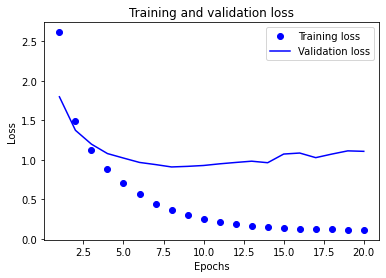

In [68]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


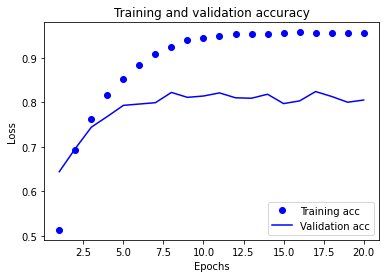

In [69]:
plt.clf()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Use Less Epoch

In [70]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(partial_x_train,
          partial_y_train,
          epochs=9,
          batch_size=512,
          validation_data=(x_val, y_val))
results = model.evaluate(x_test, one_hot_test_labels)

Epoch 1/9
16/16 [==============================] - 1s 24ms/step - loss: 2.5756 - accuracy: 0.5400 - val_loss: 1.6917 - val_accuracy: 0.6370
Epoch 2/9
16/16 [==============================] - 0s 15ms/step - loss: 1.3936 - accuracy: 0.7152 - val_loss: 1.2912 - val_accuracy: 0.7320
Epoch 3/9
16/16 [==============================] - 0s 15ms/step - loss: 1.0465 - accuracy: 0.7836 - val_loss: 1.1247 - val_accuracy: 0.7580
Epoch 4/9
16/16 [==============================] - 0s 16ms/step - loss: 0.8245 - accuracy: 0.8235 - val_loss: 1.0442 - val_accuracy: 0.7700
Epoch 5/9
16/16 [==============================] - 0s 17ms/step - loss: 0.6631 - accuracy: 0.8520 - val_loss: 0.9582 - val_accuracy: 0.8020
Epoch 6/9
16/16 [==============================] - 0s 15ms/step - loss: 0.5284 - accuracy: 0.8866 - val_loss: 0.9233 - val_accuracy: 0.8010
Epoch 7/9
16/16 [==============================] - 0s 15ms/step - loss: 0.4289 - accuracy: 0.9070 - val_loss: 0.9087 - val_accuracy: 0.8110
Epoch 8/9
16/16 [===

In [71]:
x_test[0].shape

(10000,)

In [72]:
x_test[0:2].shape

(2, 10000)

In [73]:
# note, when we want to do prediction, if the input is one sample, then need to match the input dimension
model.predict(x_test[0].reshape(1, 10000)).shape

(1, 46)

In [74]:
# predicts multiple samples are also possible
model.predict(x_test[0:2]).shape

(2, 46)

##  A different way to handle labels and loss

In [75]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [78]:
y_train

array([ 3,  4,  3, ..., 25,  3, 25])

The only thing this approach would change is the choice of the loss function. The loss function used in listing 3.21, categorical_crossentropy, expects the labels to follow a categorical encoding. With integer labels, you should use sparse_categorical_ crossentropy:

In [79]:

model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
metrics=['acc'])

# Regression Example: The Boston Housing Price Dataset

You’ll attempt to predict the median price of homes in a given Boston suburb in the mid-1970s, given data points about the suburb at the time, such as the crime rate, the local property tax rate, and so on. The dataset you’ll use has an interesting difference from the two previous examples. It has relatively few data points: only 506, split between 404 training samples and 102 test samples. And each feature in the input data (for example, the crime rate) has a different scale. For instance, some values are proportions, which take values between 0 and 1; others take values between 1 and 12, others between 0 and 100, and so on.

In [80]:
 from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

65536/57026 [==================================] - 0s 6us/step


Train_data has 13 feature (float values), then to predict train_target --> house price

In [81]:
print(train_data.shape)
print(train_targets.shape)

(404, 13)
(404,)


Normalize the data, compute the mean and variance (feature-wise) of train data, apply them to the test as well.

In [86]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

#You should never use in your workflow any quantity computed on the test data, even for something as simple as data normalization.
#
test_data -= mean
test_data /= std

### Build Model

In [87]:

from tensorflow.keras import models
from tensorflow.keras import layers

In [88]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

Note that you compile the network with the mse loss function—mean squared error, the square of the difference between the predictions and the targets. This is a widely used loss function for regression problems.
You’re also monitoring a new metric during training: mean absolute error (MAE). It’s the absolute value of the difference between the predictions and the targets. For instance, an MAE of 0.5 on this problem would mean your predictions are off by $500 on average.


### K-fold Validation Implementation

Simple example, to show how to split validation and train data, and then average validation (mae) metrics.
There are k-folds, thus k validation mae.

In [90]:
import numpy as np
k=4
num_val_samples = len(train_data) // k 
num_epochs = 100
all_scores = []

In [91]:
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] 
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate( [train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate( [train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)
    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    
    # evaluate with validation dataset, return the useful mae and mse
    # save mae, and will be averaged later.
    
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [92]:
print(all_scores)
print(np.mean(all_scores))

[2.1505322456359863, 2.35269832611084, 2.8313000202178955, 2.420611619949341]
2.4387855529785156


### Saving Validation Log for Each Epoch

In [100]:
#num_epochs = 500 
num_epochs = 250 # use 300, since we know from the book, after 80 it's overfitting
all_mae_histories = [] 
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate( [train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate( [train_targets[:i * num_val_samples], train_targets[(i + 1) * num_val_samples:]], axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets), epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae'] # a bug here, use val_mae since tensorflow changed the name
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


In [101]:
print(history.history.keys())

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


In [102]:
# average on the k-folds, for each epoch
average_mae_history = [ np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

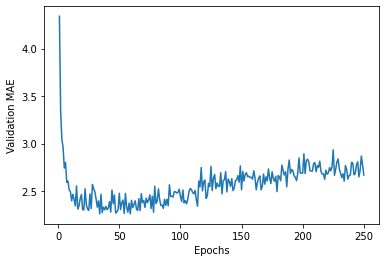

In [103]:
# plot

import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

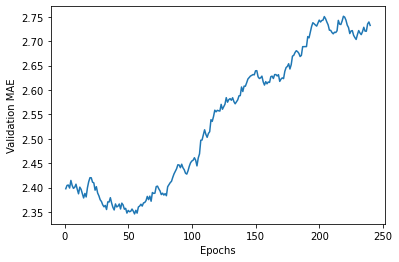

In [105]:
# smooth with moving average then plot
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

According to this plot, validation MAE stops improving significantly after 80 epochs. Past that point, you start overfitting.

In [112]:
model = build_model()
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0) # how do you determine your batch size ? 
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 917us/step - loss: 13.5796 - mae: 2.6429
